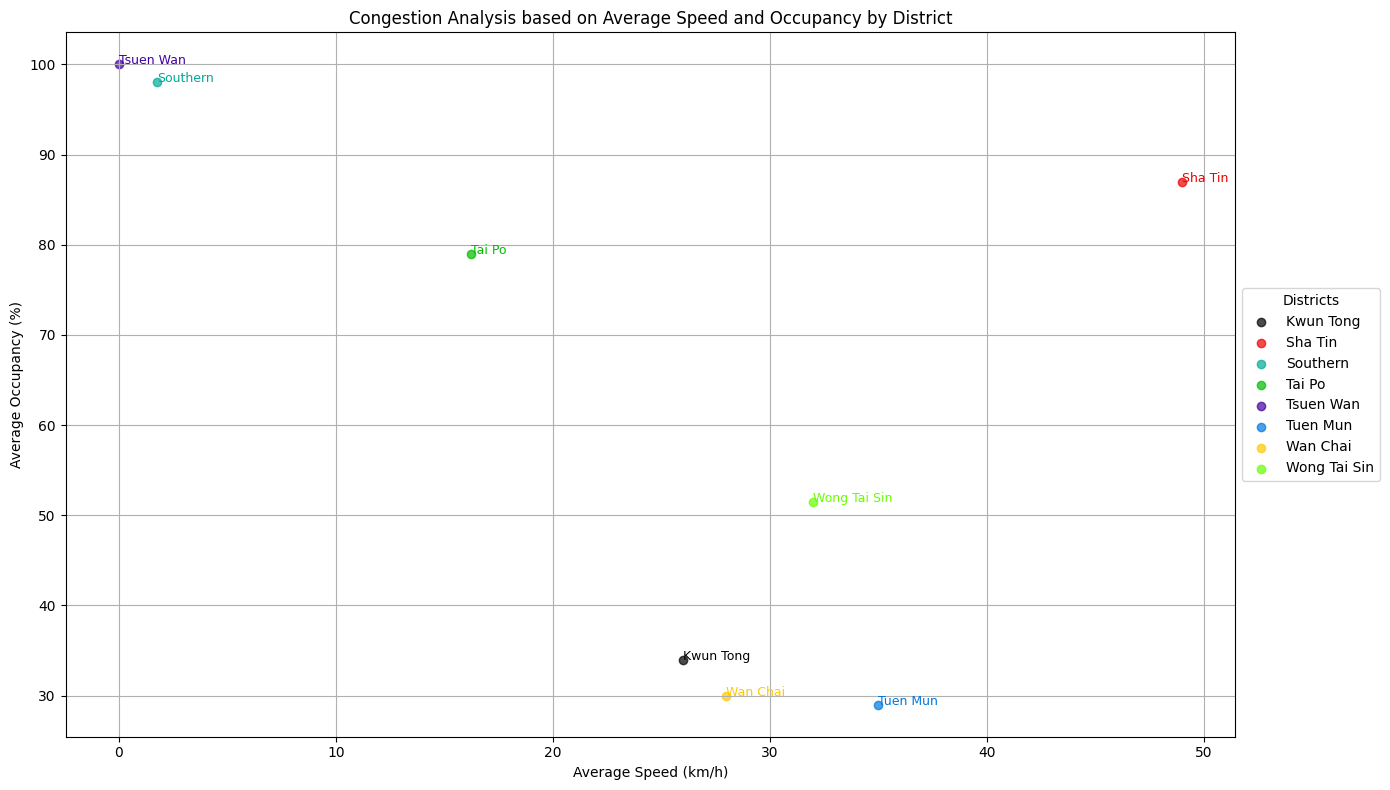

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the traffic data
traffic_data_path = 'traffic_data.csv'
traffic_data = pd.read_csv(traffic_data_path)

detectors_data_path = 'cleaned-traffic-detectors.csv'
detectors_data = pd.read_csv(detectors_data_path)


congestion_indicators = traffic_data[(traffic_data['occupancy'] > 25) & (traffic_data['speed'] < 50)]

congestion_locations = pd.merge(congestion_indicators, detectors_data, left_on='AID_ID_Number', right_on='AID_ID_Number')

districts = congestion_locations['District'].unique()
colors = {district: plt.cm.nipy_spectral(i / len(districts)) for i, district in enumerate(districts)}

agg_congestion_locations = congestion_locations.groupby('District').agg({'speed': 'mean', 'occupancy': 'mean'}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
for i, row in agg_congestion_locations.iterrows():
    ax.scatter(row['speed'], row['occupancy'], color=colors[row['District']], label=row['District'], alpha=0.7)
    ax.text(row['speed'], row['occupancy'], row['District'], color=colors[row['District']], fontsize=9)

# Handling the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), title="Districts")

ax.set_title('Congestion Analysis based on Average Speed and Occupancy by District')
ax.set_xlabel('Average Speed (km/h)')
ax.set_ylabel('Average Occupancy (%)')
ax.grid(True)

plt.tight_layout()
plt.show()


Cluster Ratios (Occupancy to Volume):
cluster
0     0.876412
1     1.035444
2    10.212644
dtype: float64


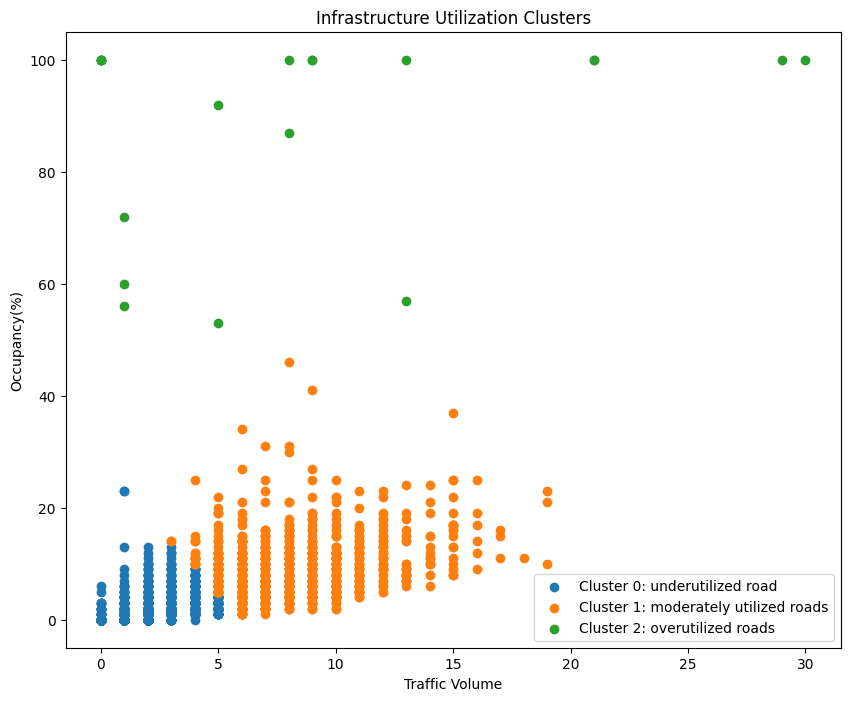

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the datasets
traffic_data = pd.read_csv('traffic_data.csv')
cleaned_traffic_detectors = pd.read_csv('cleaned-traffic-detectors.csv')

# Merge the datasets on a common column (e.g., 'detector_id')
merged_data = pd.merge(traffic_data, cleaned_traffic_detectors, on='AID_ID_Number')

merged_data['volume'] = pd.to_numeric(merged_data['volume'], errors='coerce')
merged_data['occupancy'] = pd.to_numeric(merged_data['occupancy'], errors='coerce')

merged_data.dropna(subset=['volume', 'occupancy'], inplace=True)


features = merged_data[['volume', 'occupancy']]

normalized_features = (features - features.mean()) / features.std()

kmeans = KMeans(n_clusters=3)  
kmeans.fit(normalized_features)

# Add cluster labels to the original data
merged_data['cluster'] = kmeans.labels_

# Calculate the mean values for each cluster
cluster_means = merged_data.groupby('cluster')[['volume', 'occupancy']].mean()

ratios = cluster_means['occupancy'] / cluster_means['volume']
print("Cluster Ratios (Occupancy to Volume):")
print(ratios)


cluster_names = {}
for i, row in cluster_means.iterrows():
    ratio = row['occupancy'] / row['volume']
    if 1 < ratio < 1.5:
        cluster_names[i] = 'moderately utilized roads'
    elif ratio < 1:
        cluster_names[i] = 'underutilized road'
    else:
        cluster_names[i] = 'overutilized roads'


# Plot the clusters with corrected names
plt.figure(figsize=(10, 8))
for cluster_label, cluster_name in cluster_names.items():
    cluster_data = merged_data[merged_data['cluster'] == cluster_label]
    plt.scatter(cluster_data['volume'], cluster_data['occupancy'], label=f'Cluster {cluster_label}: {cluster_name}')

plt.xlabel('Traffic Volume')
plt.ylabel('Occupancy(%)')
plt.title('Infrastructure Utilization Clusters')
plt.legend()
plt.show()